# Time series prediction using an RNN with PyTorch

## 1. Import & Preprocessing

### a) Importing modules

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


import torch
import torch.nn as nn
import torch.optim as optim

### b) Importing data

In [ ]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [ ]:
flight_data.shape

(144, 3)

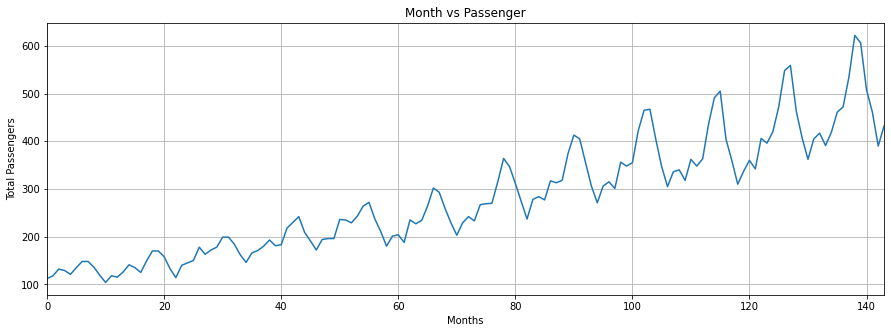

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

### c) Data preparation

In [ ]:
data = flight_data['passengers']

In [ ]:
test_size = 12

x_train = data[:-test_size].values.astype(float)
x_test = data[-test_size:].values.astype(float)

In [ ]:
x_train.shape

(132,)

In [ ]:
x_test.shape

(12,)

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
x_train = scaler.fit_transform(x_train.reshape(-1, 1))

In [ ]:
x_train.shape

(132, 1)

## 2. Model specific data preparation

### a) Load the data

In [ ]:
x_train_pt = torch.FloatTensor(x_train).squeeze()

In [ ]:
x_train_pt.shape

torch.Size([132])

In [ ]:
def create_sequences(input_data, window=12):
    seq = []
    L = len(input_data)
    for i in range(L-window):
        train_seq = input_data[i:i+window]
        train_label = input_data[i+window:i+window+1]
        seq.append((train_seq ,train_label))
    return seq

In [ ]:
train_seq_pt = create_sequences(x_train_pt)

In [ ]:
len(train_seq_pt)

120

### b) Tensor view of the data

In [ ]:
train_seq_pt[0]

(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
         -0.8593, -0.9341, -1.0000, -0.9385]), tensor([-0.9516]))

## 3. Model definition

### a) Build the model

In [ ]:
def init_weights(self):
        for m in self.modules():
            if type(m) in [nn.Linear, nn.LSTM]:
                for name, param in m.named_parameters():
                    if 'weight_ih' in name or name == 'weight':
                        torch.nn.init.uniform_(param.data, -1,1)
                    elif 'weight_hh' in name:
                        torch.nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        param.data.fill_(0)

In [ ]:
class LSTM_PT(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, inputs):
        h0, c0 = self.init_hidden(inputs)
        lstm_out, (hn, cn) = self.lstm(inputs.view(len(inputs) ,-1, 1))
        predictions = self.linear(lstm_out.view(len(inputs), -1))
        return predictions[-1]

    def init_hidden(self, x):
        h0 = torch.zeros(1,1,self.hidden_layer_size)
        c0 = torch.zeros(1,1,self.hidden_layer_size)
        return [t for t in (h0, c0)]

model_pt = LSTM_PT()

In [ ]:
model_pt.apply(init_weights)

LSTM_PT(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

### b) Inspect the model

In [ ]:
params_pt = model_pt.named_parameters()
for name, param in params_pt:
  print(name)

lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
linear.weight
linear.bias


### c) Inspect the first hidden layer

In [ ]:
model_pt.lstm._parameters['weight_ih_l0']

Parameter containing:
tensor([[ 7.5436e-03],
        [-9.0757e-01],
        [ 4.9474e-01],
        [-1.9748e-02],
        [-4.1581e-01],
        [-8.1391e-01],
        [ 2.4360e-01],
        [-5.3848e-01],
        [ 9.9178e-01],
        [ 5.2769e-02],
        [-6.8712e-01],
        [-6.2675e-01],
        [-2.6106e-01],
        [ 5.2523e-01],
        [ 5.0070e-01],
        [-7.4434e-01],
        [ 8.4302e-01],
        [-7.1562e-01],
        [-8.1817e-01],
        [ 4.6565e-01],
        [ 6.8202e-01],
        [ 6.3464e-01],
        [-2.8164e-01],
        [ 7.0539e-01],
        [-3.4682e-01],
        [ 1.5032e-01],
        [ 5.5950e-01],
        [-4.6837e-01],
        [-4.3061e-01],
        [ 9.7801e-01],
        [ 1.4264e-01],
        [ 3.3180e-01],
        [-9.2078e-02],
        [-9.7589e-01],
        [ 3.6548e-01],
        [-1.8703e-01],
        [-8.5933e-01],
        [ 8.4420e-01],
        [-7.2446e-01],
        [ 3.4702e-01],
        [-9.3834e-02],
        [-1.2796e-01],
        [ 9.

In [ ]:
model_pt.lstm._parameters['weight_ih_l0'].shape

torch.Size([400, 1])

In [ ]:
model_pt.lstm._parameters['bias_ih_l0']

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.

In [ ]:
model_pt.lstm._parameters['bias_ih_l0'].shape

torch.Size([400])

## 4. Loss & Optimizer

In [ ]:
optimizer_pt = torch.optim.Adam(model_pt.parameters())
loss_fn_pt = nn.MSELoss()

## 5. Training

### a) Training loop

In [ ]:
def train_step_pt(model, optimizer, loss_fn, sequence):
  total_loss = 0.0

  for seq, label in sequence:
    optimizer.zero_grad()
    y_pred_pt = model(seq)
          
    loss = loss_fn(y_pred_pt,label)

    loss.backward()
    optimizer.step()
    total_loss += np.sum(loss.data.numpy())
  return total_loss/len(seq)

In [ ]:
train_loss_pt = []

epochs = 25
for epoch in range(epochs):
  
  loss = train_step_pt(model_pt, optimizer_pt, loss_fn_pt,train_seq_pt)
  train_loss_pt.append(loss)

  template = ("Epoch {}, Loss: {}")
  print(template.format(epoch+1, loss))

Epoch 1, Loss: 0.895357415085229
Epoch 2, Loss: 0.8234581336054513
Epoch 3, Loss: 0.3087507461691909
Epoch 4, Loss: 0.3231701800078402
Epoch 5, Loss: 0.36058041845520467
Epoch 6, Loss: 0.21181213449839711
Epoch 7, Loss: 0.2937254602226555
Epoch 8, Loss: 0.20443397051351062
Epoch 9, Loss: 0.2979670363305331
Epoch 10, Loss: 0.24070109548398477
Epoch 11, Loss: 0.3545712364372922
Epoch 12, Loss: 0.29855455018813853
Epoch 13, Loss: 0.3627543940999658
Epoch 14, Loss: 0.21053995351827362
Epoch 15, Loss: 0.2109293579112356
Epoch 16, Loss: 0.18583531574754866
Epoch 17, Loss: 0.22544338311684964
Epoch 18, Loss: 0.35660786081634416
Epoch 19, Loss: 0.2513921297113484
Epoch 20, Loss: 0.223042339286053
Epoch 21, Loss: 0.14770570832709495
Epoch 22, Loss: 0.21863402207069763
Epoch 23, Loss: 0.19467673348603873
Epoch 24, Loss: 0.3477332680498059
Epoch 25, Loss: 0.21799521599738605


### b) Training progress

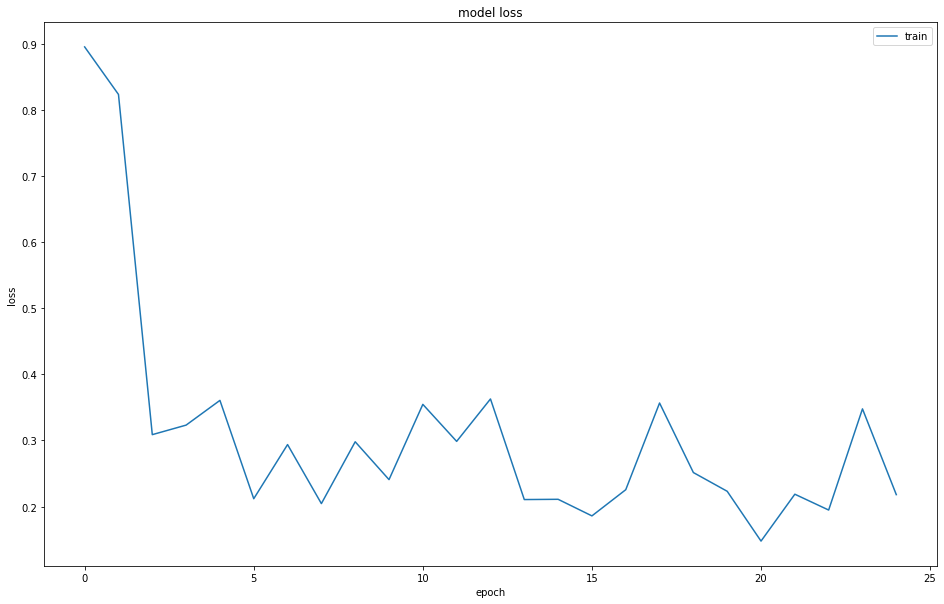

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(train_loss_pt)
#plt.plot(test_loss_tf)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

### c) Inspect the first hidden layer after training

In [ ]:
model_pt.lstm._parameters['weight_ih_l0']

Parameter containing:
tensor([[ 0.0542],
        [-0.8515],
        [ 0.5120],
        [-0.0058],
        [-0.3911],
        [-0.8090],
        [ 0.2488],
        [-0.3953],
        [ 1.0214],
        [ 0.0744],
        [-0.6185],
        [-0.5319],
        [-0.2165],
        [ 0.5325],
        [ 0.5482],
        [-0.7427],
        [ 0.8574],
        [-0.6820],
        [-0.7851],
        [ 0.4709],
        [ 0.7090],
        [ 0.6476],
        [-0.2473],
        [ 0.7340],
        [-0.3241],
        [ 0.2386],
        [ 0.5707],
        [-0.4470],
        [-0.4398],
        [ 0.9996],
        [ 0.1562],
        [ 0.3629],
        [-0.0822],
        [-0.9720],
        [ 0.4006],
        [-0.1332],
        [-0.8433],
        [ 0.9115],
        [-0.6949],
        [ 0.3687],
        [-0.1008],
        [-0.0656],
        [ 1.0137],
        [-0.5839],
        [ 0.7235],
        [-0.7363],
        [ 1.0069],
        [-0.6710],
        [ 0.6878],
        [-0.4165],
        [-0.1492],
        [

In [ ]:
model_pt.lstm._parameters['bias_ih_l0']

Parameter containing:
tensor([-0.0192, -0.0859, -0.0356, -0.1045, -0.0111, -0.0663, -0.0941, -0.0423,
        -0.0303, -0.0555, -0.0104,  0.0064, -0.0561, -0.0857, -0.0794,  0.0032,
        -0.0932, -0.0563, -0.0185, -0.1181, -0.0252, -0.0226, -0.0999, -0.0588,
        -0.0459, -0.0882, -0.0929, -0.0395, -0.0796, -0.0215, -0.0222, -0.0801,
        -0.0679, -0.0645, -0.0848, -0.0254,  0.0013, -0.0259, -0.0314, -0.0889,
        -0.0933, -0.1156, -0.1187, -0.0423, -0.0162, -0.1100, -0.0074, -0.0990,
        -0.0611, -0.0344,  0.0566, -0.0846, -0.1123, -0.0529, -0.0066, -0.0134,
        -0.0879, -0.0760, -0.0080, -0.0123, -0.0086,  0.0152,  0.2181, -0.0413,
        -0.0906, -0.0235, -0.0125, -0.0715, -0.0653, -0.0910, -0.0097, -0.0257,
        -0.0104, -0.0971, -0.1134, -0.0116, -0.0142, -0.2410, -0.0635, -0.1152,
        -0.0805, -0.0221, -0.1277, -0.0352, -0.1423, -0.0813, -0.0087, -0.0691,
        -0.1341, -0.0005, -0.1477, -0.0657, -0.0181, -0.0320, -0.0323, -0.1353,
        -0.0195, -

## 6. Evaluation

### a) Prediction comparing to the test set

In [ ]:
test_inputs_overlap_pt = x_train[-12:].tolist()

In [ ]:
test_inputs_overlap_pt

[[0.12527472527472527],
 [0.04615384615384621],
 [0.32747252747252764],
 [0.2835164835164836],
 [0.3890109890109892],
 [0.6175824175824178],
 [0.9516483516483516],
 [1.0000000000000002],
 [0.578021978021978],
 [0.331868131868132],
 [0.13406593406593403],
 [0.32307692307692304]]

In [ ]:
for i in range(12):
    seq = torch.FloatTensor(test_inputs_overlap_pt[-12:])
    with torch.no_grad():
        test_inputs_overlap_pt.append([model_pt(seq).item()])

In [ ]:
test_inputs_overlap_pt[-12:]

[[0.5563382506370544],
 [0.75697261095047],
 [0.9064080715179443],
 [0.9572950601577759],
 [0.9222853183746338],
 [0.8647569417953491],
 [0.8369809985160828],
 [0.7945814728736877],
 [0.6816402673721313],
 [0.5714738368988037],
 [0.5549083948135376],
 [0.6745378375053406]]

In [ ]:
overlap_predictions_pt = scaler.inverse_transform(np.array(test_inputs_overlap_pt[-12:] ).reshape(-1, 1))
print(overlap_predictions_pt)

[[458.06695202]
 [503.71126899]
 [537.70783627]
 [549.28462619]
 [541.31990993]
 [528.23220426]
 [521.91317716]
 [512.26728508]
 [486.57316083]
 [461.51029789]
 [457.74165982]
 [484.95735803]]


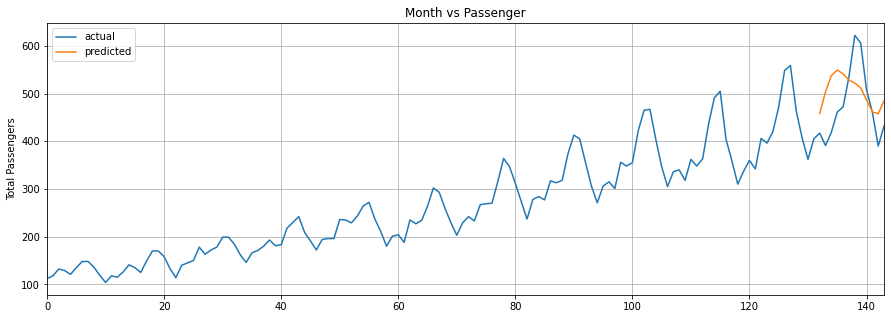

In [ ]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(np.arange(132, 144, 1),overlap_predictions_pt)
plt.legend(['actual', 'predicted'], loc='upper left')
plt.show()

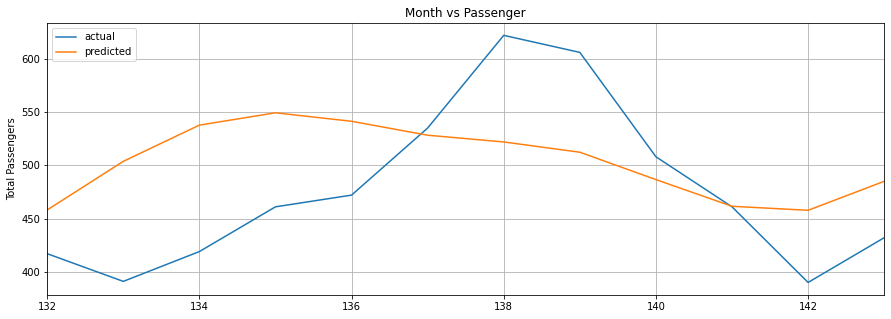

In [ ]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'][-12:])
plt.plot(np.arange(132, 144, 1),overlap_predictions_pt)
plt.legend(['actual', 'predicted'], loc='upper left')
plt.show()

### b) Prediction into the future using the test set

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
x_test_pt = scaler.fit_transform(x_test.reshape(-1, 1))

In [ ]:
test_inputs_pt = x_test_pt[-12:].tolist()

In [ ]:
test_inputs_pt

[[-0.7672413793103456],
 [-0.9913793103448283],
 [-0.7500000000000004],
 [-0.38793103448275934],
 [-0.293103448275863],
 [0.2499999999999991],
 [0.9999999999999991],
 [0.8620689655172411],
 [0.017241379310344307],
 [-0.38793103448275934],
 [-1.0000000000000004],
 [-0.6379310344827593]]

In [ ]:
for i in range(12):
    seq = torch.FloatTensor(test_inputs_pt[-12:])
    with torch.no_grad():
        test_inputs_pt.append([model_pt(seq).item()])

In [ ]:
test_inputs_pt[-12:]

[[-0.5371994376182556],
 [-0.46582120656967163],
 [-0.3862862288951874],
 [-0.31029900908470154],
 [-0.24676504731178284],
 [-0.20309317111968994],
 [-0.18405966460704803],
 [-0.19027894735336304],
 [-0.21399196982383728],
 [-0.24165986478328705],
 [-0.2637673318386078],
 [-0.2749954164028168]]

In [ ]:
predictions_pt = scaler.inverse_transform(np.array(test_inputs_pt[-12:] ).reshape(-1, 1))
print(predictions_pt)

[[443.68486524]
 [451.96474004]
 [461.19079745]
 [470.00531495]
 [477.37525451]
 [482.44119215]
 [484.64907891]
 [483.92764211]
 [481.1769315 ]
 [477.96745569]
 [475.40298951]
 [474.1005317 ]]


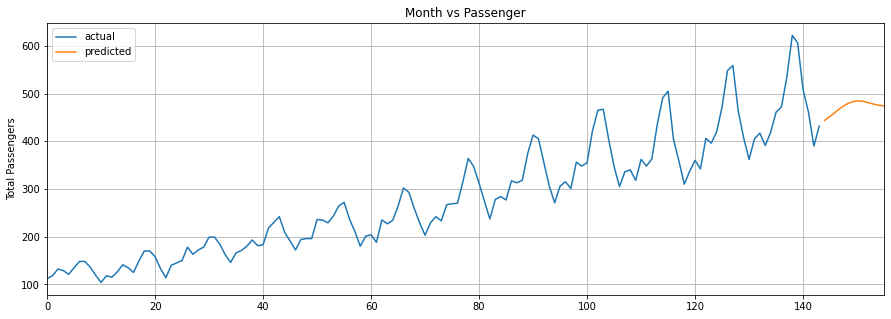

In [ ]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(np.arange(144, 156, 1),predictions_pt)
plt.legend(['actual', 'predicted'], loc='upper left')
plt.show()

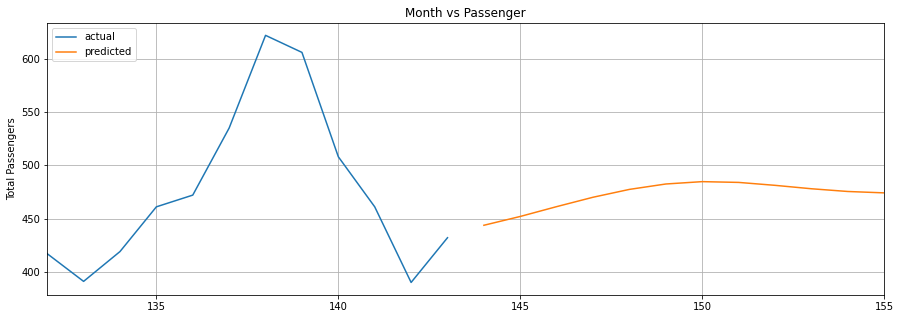

In [ ]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'][-12:])
plt.plot(np.arange(144, 156, 1),predictions_pt)
plt.legend(['actual', 'predicted'], loc='upper left')
plt.show()